In [2]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline
import pandas as pd;
import matplotlib.pyplot as plt
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RNN, SimpleRNN
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers.core import Activation
from keras.callbacks import LambdaCallback
from sklearn.preprocessing import MinMaxScaler

In [3]:
train = pd.read_csv("train.csv", 
                    parse_dates = True, low_memory = False, index_col = 'Date')

# additional store data
store = pd.read_csv("store.csv", 
                    low_memory = False)

In [4]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [5]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
# data extraction
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

# adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

In [7]:
train_data = train[train.Store == 1]
train_data = train_data[(train_data["Open"] != 0) & (train_data['Sales'] != 0)]
train_data=train_data.sort_index()
train_data=train_data.fillna(0)
train_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2013-01-02,1,3,5530,668,1,0,0,1,2013,1,2,1,8.278443
2013-01-03,1,4,4327,578,1,0,0,1,2013,1,3,1,7.486159
2013-01-04,1,5,4486,619,1,0,0,1,2013,1,4,1,7.247173
2013-01-05,1,6,4997,635,1,0,0,1,2013,1,5,1,7.869291
2013-01-07,1,1,7176,785,1,1,0,1,2013,1,7,2,9.141401


In [8]:
train_data_X = train_data[['Month', 'Day', 'WeekOfYear','DayOfWeek' , 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'SalePerCustomer']]

In [9]:
train_data_y = train_data[['Sales']]

In [10]:
# X_train = train_data_X.head(730)
# X_test = train_data_X.tail(50)
# y_train = train_data_y.head(730)
# y_test = train_data_y.tail(50)

number_of_test_data = 50
number_of_holdout_data = 50
number_of_training_data = len(train_data) - number_of_holdout_data - number_of_test_data
print ("total, train, test, holdout:", len(train_data), number_of_training_data, number_of_test_data, number_of_holdout_data)

total, train, test, holdout: 781 681 50 50


In [11]:
datatrain = train_data[:number_of_training_data]
datatest = train_data[-(number_of_test_data+number_of_holdout_data):-number_of_holdout_data]
datahold = train_data[-number_of_holdout_data:]
datatrain.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2013-01-02,1,3,5530,668,1,0,0,1,2013,1,2,1,8.278443
2013-01-03,1,4,4327,578,1,0,0,1,2013,1,3,1,7.486159
2013-01-04,1,5,4486,619,1,0,0,1,2013,1,4,1,7.247173
2013-01-05,1,6,4997,635,1,0,0,1,2013,1,5,1,7.869291
2013-01-07,1,1,7176,785,1,1,0,1,2013,1,7,2,9.141401


In [40]:
datahold

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-06-03,1,3,5809,616,1,1,0,0,2015,6,3,23,9.430195
2015-06-05,1,5,5384,609,1,1,0,0,2015,6,5,23,8.840722
2015-06-06,1,6,4183,460,1,0,0,0,2015,6,6,23,9.093478
2015-06-08,1,1,4071,502,1,0,0,0,2015,6,8,24,8.109562
2015-06-09,1,2,4102,485,1,0,0,0,2015,6,9,24,8.457732
2015-06-10,1,3,3591,453,1,0,0,0,2015,6,10,24,7.927152
2015-06-11,1,4,3627,442,1,0,0,0,2015,6,11,24,8.205882
2015-06-12,1,5,3695,422,1,0,0,0,2015,6,12,24,8.755924
2015-06-13,1,6,4256,502,1,0,0,0,2015,6,13,24,8.478088


In [12]:
in_seq1 = array(datatrain['Month'])
in_seq2 = array(datatrain['Day'])
in_seq3 = array(datatrain['WeekOfYear'])
in_seq4 = array(datatrain['DayOfWeek'])
in_seq5 = array(datatrain['Open'])
in_seq6 = array(datatrain['Promo'])
in_seq7 = array(datatrain['StateHoliday'])
in_seq8 = array(datatrain['SchoolHoliday'])
in_seq9 = array(datatrain['SalePerCustomer'])

out_seq_train = array(datatrain['Sales'])

In [13]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
out_seq_train = out_seq_train.reshape((len(out_seq_train), 1))


In [14]:
datatrain_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, out_seq_train))
datatrain_feed

array([[1, 2, 1, ..., 1, 8.278443113772456, 5530],
       [1, 3, 1, ..., 1, 7.486159169550173, 4327],
       [1, 4, 1, ..., 1, 7.247172859450727, 4486],
       ...,
       [3, 27, 13, ..., 0, 7.570888468809073, 4005],
       [3, 28, 13, ..., 0, 8.608264462809917, 5208],
       [3, 30, 14, ..., 1, 9.63271162123386, 6714]], dtype=object)

In [15]:
in_seq1 = array(datahold['Month'])
in_seq2 = array(datahold['Day'])
in_seq3 = array(datahold['WeekOfYear'])
in_seq4 = array(datahold['DayOfWeek'])
in_seq5 = array(datahold['Open'])
in_seq6 = array(datahold['Promo'])
in_seq7 = array(datahold['StateHoliday'])
in_seq8 = array(datahold['SchoolHoliday'])
in_seq9 = array(datahold['SalePerCustomer'])

out_seq_hold = array(datahold['Sales'])

In [16]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
out_seq_hold = out_seq_hold.reshape((len(out_seq_hold), 1))
out_seq_hold.shape

(50, 1)

In [17]:
datathold_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, out_seq_hold))
datathold_feed

array([[6, 3, 23, 3, 1, 1, '0', 0, 9.430194805194805, 5809],
       [6, 5, 23, 5, 1, 1, '0', 0, 8.84072249589491, 5384],
       [6, 6, 23, 6, 1, 0, '0', 0, 9.093478260869565, 4183],
       [6, 8, 24, 1, 1, 0, '0', 0, 8.109561752988048, 4071],
       [6, 9, 24, 2, 1, 0, '0', 0, 8.457731958762887, 4102],
       [6, 10, 24, 3, 1, 0, '0', 0, 7.927152317880795, 3591],
       [6, 11, 24, 4, 1, 0, '0', 0, 8.205882352941176, 3627],
       [6, 12, 24, 5, 1, 0, '0', 0, 8.755924170616113, 3695],
       [6, 13, 24, 6, 1, 0, '0', 0, 8.47808764940239, 4256],
       [6, 15, 25, 1, 1, 1, '0', 0, 9.416382252559726, 5518],
       [6, 16, 25, 2, 1, 1, '0', 0, 9.646123260437376, 4852],
       [6, 17, 25, 3, 1, 1, '0', 0, 8.403361344537815, 4000],
       [6, 18, 25, 4, 1, 1, '0', 0, 9.32730923694779, 4645],
       [6, 19, 25, 5, 1, 1, '0', 0, 8.628336755646817, 4202],
       [6, 20, 25, 6, 1, 0, '0', 0, 8.293522267206479, 4097],
       [6, 22, 26, 1, 1, 0, '0', 0, 7.865030674846626, 3846],
       [6, 23, 2

In [18]:
in_seq1 = array(datatest['Month'])
in_seq2 = array(datatest['Day'])
in_seq3 = array(datatest['WeekOfYear'])
in_seq4 = array(datatest['DayOfWeek'])
in_seq5 = array(datatest['Open'])
in_seq6 = array(datatest['Promo'])
in_seq7 = array(datatest['StateHoliday'])
in_seq8 = array(datatest['SchoolHoliday'])
in_seq9 = array(datatest['SalePerCustomer'])

out_seq_test = array(datatest['Sales'])

In [19]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
out_seq_test = out_seq_hold.reshape((len(out_seq_test), 1))
out_seq_test.shape

(50, 1)

In [20]:
datatest_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, out_seq_test))
datatest_feed.shape

(50, 10)

In [21]:
n_features = datatrain_feed.shape[1]
n_input = 1
generator_train = TimeseriesGenerator(datatrain_feed, out_seq_train, length=n_input, batch_size=1)


In [22]:
for i in range(len(generator_train)):
    x, y = generator_train[i]
    print('%s => %s' % (x, y))

[[[1 2 1 3 1 0 '0' 1 8.278443113772456 5530]]] => [[4327]]
[[[1 3 1 4 1 0 '0' 1 7.486159169550173 4327]]] => [[4486]]
[[[1 4 1 5 1 0 '0' 1 7.247172859450727 4486]]] => [[4997]]
[[[1 5 1 6 1 0 '0' 1 7.869291338582677 4997]]] => [[7176]]
[[[1 7 2 1 1 1 '0' 1 9.14140127388535 7176]]] => [[5580]]
[[[1 8 2 2 1 1 '0' 1 8.53211009174312 5580]]] => [[5471]]
[[[1 9 2 3 1 1 '0' 1 8.73961661341853 5471]]] => [[4892]]
[[[1 10 2 4 1 1 '0' 1 7.954471544715447 4892]]] => [[4881]]
[[[1 11 2 5 1 1 '0' 1 8.244932432432432 4881]]] => [[4952]]
[[[1 12 2 6 1 0 '0' 0 7.6656346749226 4952]]] => [[4717]]
[[[1 14 3 1 1 0 '0' 0 7.657467532467533 4717]]] => [[3900]]
[[[1 15 3 2 1 0 '0' 0 7.6171875 3900]]] => [[4008]]
[[[1 16 3 3 1 0 '0' 0 7.562264150943396 4008]]] => [[4044]]
[[[1 17 3 4 1 0 '0' 0 8.03976143141153 4044]]] => [[4127]]
[[[1 18 3 5 1 0 '0' 0 7.265845070422535 4127]]] => [[5182]]
[[[1 19 3 6 1 0 '0' 0 7.531976744186046 5182]]] => [[5394]]
[[[1 21 4 1 1 1 '0' 0 8.886326194398682 5394]]] => [[5720]]
[

In [23]:
generator_hold = TimeseriesGenerator(datathold_feed, out_seq_hold, length=1, batch_size=1)

In [24]:
for i in range(len(generator_hold)):
    x, y = generator_hold[i]
    print('%s => %s' % (x, y))

[[[6 3 23 3 1 1 '0' 0 9.430194805194805 5809]]] => [[5384]]
[[[6 5 23 5 1 1 '0' 0 8.84072249589491 5384]]] => [[4183]]
[[[6 6 23 6 1 0 '0' 0 9.093478260869565 4183]]] => [[4071]]
[[[6 8 24 1 1 0 '0' 0 8.109561752988048 4071]]] => [[4102]]
[[[6 9 24 2 1 0 '0' 0 8.457731958762887 4102]]] => [[3591]]
[[[6 10 24 3 1 0 '0' 0 7.927152317880795 3591]]] => [[3627]]
[[[6 11 24 4 1 0 '0' 0 8.205882352941176 3627]]] => [[3695]]
[[[6 12 24 5 1 0 '0' 0 8.755924170616113 3695]]] => [[4256]]
[[[6 13 24 6 1 0 '0' 0 8.47808764940239 4256]]] => [[5518]]
[[[6 15 25 1 1 1 '0' 0 9.416382252559726 5518]]] => [[4852]]
[[[6 16 25 2 1 1 '0' 0 9.646123260437376 4852]]] => [[4000]]
[[[6 17 25 3 1 1 '0' 0 8.403361344537815 4000]]] => [[4645]]
[[[6 18 25 4 1 1 '0' 0 9.32730923694779 4645]]] => [[4202]]
[[[6 19 25 5 1 1 '0' 0 8.628336755646817 4202]]] => [[4097]]
[[[6 20 25 6 1 0 '0' 0 8.293522267206479 4097]]] => [[3846]]
[[[6 22 26 1 1 0 '0' 0 7.865030674846626 3846]]] => [[3762]]
[[[6 23 26 2 1 0 '0' 0 8.4161073

In [25]:
generator_test = TimeseriesGenerator(datatest_feed, out_seq_test, length=n_input, batch_size=1)

In [26]:
for i in range(len(generator_test)):
    x, y = generator_test[i]
    print('%s => %s' % (x, y))

[[[3 31 14 2 1 1 '0' 1 10.536502546689304 5809]]] => [[5384]]
[[[4 1 14 3 1 1 '0' 1 9.640735502121641 5384]]] => [[4183]]
[[[4 2 14 4 1 1 '0' 1 9.105263157894736 4183]]] => [[4071]]
[[[4 4 14 6 1 0 '0' 1 8.428391959798995 4071]]] => [[4102]]
[[[4 7 15 2 1 0 '0' 1 7.500900900900901 4102]]] => [[3591]]
[[[4 8 15 3 1 0 '0' 1 8.388 3591]]] => [[3627]]
[[[4 9 15 4 1 0 '0' 1 8.06279069767442 3627]]] => [[3695]]
[[[4 10 15 5 1 0 '0' 1 8.292056074766355 3695]]] => [[4256]]
[[[4 11 15 6 1 0 '0' 0 7.948571428571428 4256]]] => [[5518]]
[[[4 13 16 1 1 1 '0' 0 9.367595818815332 5518]]] => [[4852]]
[[[4 14 16 2 1 1 '0' 0 8.687850467289719 4852]]] => [[4000]]
[[[4 15 16 3 1 1 '0' 0 8.203592814371257 4000]]] => [[4645]]
[[[4 16 16 4 1 1 '0' 0 8.575 4645]]] => [[4202]]
[[[4 17 16 5 1 1 '0' 0 9.232876712328768 4202]]] => [[4097]]
[[[4 18 16 6 1 0 '0' 0 8.444852941176471 4097]]] => [[3846]]
[[[4 20 17 1 1 0 '0' 0 7.754166666666666 3846]]] => [[3762]]
[[[4 21 17 2 1 0 '0' 0 7.300480769230769 3762]]] => [[

In [27]:
print("timesteps, features:", n_input, n_features)

timesteps, features: 1 10


In [28]:
model = Sequential()

model.add(SimpleRNN(10, activation='relu', input_shape=(n_input, n_features), return_sequences = False))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='relu'))

adam = Adam(lr=0.003)
model.compile(optimizer=adam, loss='mse')

In [29]:
score = model.fit_generator(generator_train, epochs=1000, verbose=2, validation_data=generator_test)

Epoch 1/1000
 - 2s - loss: 1942847.6531 - val_loss: 160833.5000
Epoch 2/1000
 - 1s - loss: 709447.0685 - val_loss: 155040.5938
Epoch 3/1000
 - 1s - loss: 700601.4724 - val_loss: 82679.2734
Epoch 4/1000
 - 1s - loss: 694624.0136 - val_loss: 147290.2969
Epoch 5/1000
 - 1s - loss: 703789.9197 - val_loss: 100249.8438
Epoch 6/1000
 - 1s - loss: 690544.7220 - val_loss: 85923.1250
Epoch 7/1000
 - 1s - loss: 725797.0100 - val_loss: 194387.9844
Epoch 8/1000
 - 1s - loss: 692333.7054 - val_loss: 31765.9258
Epoch 9/1000
 - 1s - loss: 669946.3656 - val_loss: 105745.9609
Epoch 10/1000
 - 1s - loss: 683451.1662 - val_loss: 484896.6562
Epoch 11/1000
 - 1s - loss: 680139.2216 - val_loss: 275048.5312
Epoch 12/1000
 - 1s - loss: 702022.9009 - val_loss: 283847.0000
Epoch 13/1000
 - 1s - loss: 684031.1846 - val_loss: 42.1105
Epoch 14/1000
 - 1s - loss: 693512.3669 - val_loss: 150929.2188
Epoch 15/1000
 - 1s - loss: 682656.5632 - val_loss: 135681.0781
Epoch 16/1000
 - 1s - loss: 664960.7140 - val_loss: 229

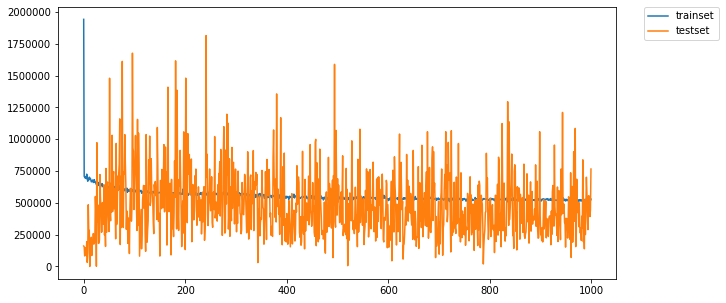

In [30]:
losses = score.history['loss']
val_losses = score.history['val_loss']
plt.figure(figsize=(10,5))
plt.plot(losses, label="trainset")
plt.plot(val_losses, label="testset")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [31]:
yhat = model.predict(generator_test, verbose=2)

In [32]:
yhat.shape

(49, 1)

In [33]:
df_result = pd.DataFrame({'Actual' : [], 'Prediction' : []})

for i in range(len(generator_test)):
    x, y = generator_test[i]
    x_input = array(x).reshape((1, n_input, n_features))
    yhat = model.predict(x_input, verbose=2)
    df_result = df_result.append({'Actual': y[0][0], 'Prediction': yhat[0][0]}, ignore_index=True)

In [38]:
df_result.head(50)

,Actual,Prediction
0,5384.0,5074.799805
1,4183.0,4751.117188
2,4071.0,4048.356445
3,4102.0,4121.193848
4,3591.0,3615.706055
5,3627.0,3441.273438
6,3695.0,3580.070312
7,4256.0,3765.415527
8,5518.0,4359.550293
9,4852.0,4738.529297


In [35]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(df_result.Actual, df_result.Prediction))
print(rmse)

586.207584988249


In [36]:
MAPE= np.mean(np.abs((df_result.Actual - df_result.Prediction) / df_result.Actual)) * 100
print(MAPE)

9.171793803883608


In [37]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# error = metrics.mean_absolute_error(train_Y, y_pred)

In [51]:
mean_absolute_error(df_result.Actual, df_result.Prediction)

442.4894571109694